# LANL Earthquake Prediction

# Step 1. Load packages

In [1]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor,Pool
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import matplotlib.patches as patch
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import skew
from scipy.stats import norm
from scipy import linalg
from sklearn import tree
from sklearn import svm
import lightgbm as lgb
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import warnings
import random
import eli5
import time
import glob
import sys
import os

C:\Users\yan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Step 2. Load the data

In [2]:
train_df = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [4]:
print("rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

rows:629145480 cols:2


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


# Step 3. Data exploration
>
> 1. acoustic_data : 實驗測量到的聲波信號
> 2. time to failure : 地震發生時的信號
>
> 由於有6億多筆資料，所以我們先繪製其中1%的資料做觀察

In [6]:
mini_train_ad = train_df['acoustic_data'].values[::100]
mini_train_ttf = train_df['time_to_failure'].values[::100]

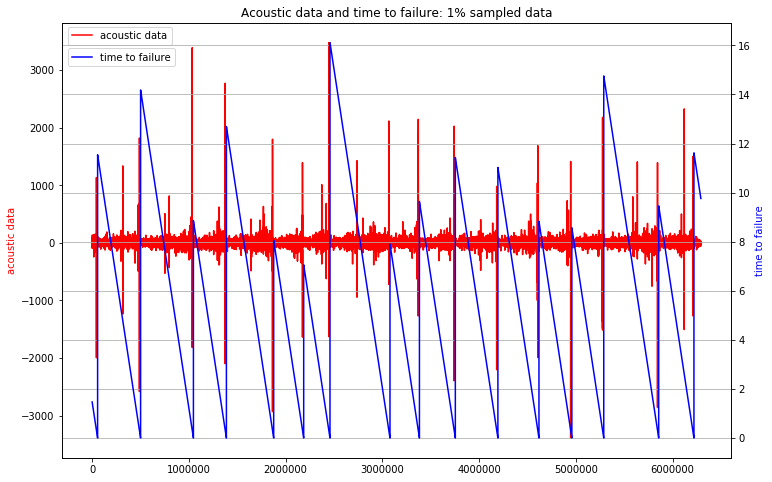

In [7]:
def plot_acc_ttf_data(mini_train_ad, mini_train_ttf, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(mini_train_ad, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(mini_train_ttf, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(mini_train_ad, mini_train_ttf)
del mini_train_ad
del mini_train_ttf

> 從這張圖可以看出每當地震發生之前，聲波的幅度都會大幅增加，
>
> 接著我們把時間圖放大再仔細觀察。

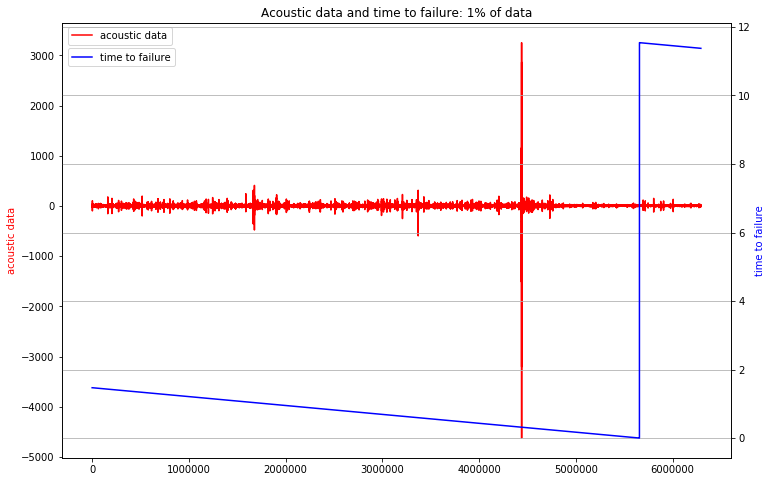

In [8]:
mini_train_ad = train_df['acoustic_data'].values[:6291455]
mini_train_ttf = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(mini_train_ad, mini_train_ttf, title="Acoustic data and time to failure: 1% of data")
del mini_train_ad
del mini_train_ttf

>在這個放大的時間圖中，我們發現在地震前的信號的大幅波動並不是最後一刻才發生，
>
>再大幅波動後還有一些較小峰值得波動才發生地震。

# Step 4. Data Preprocessing
>
>由於train的資料集太多且能分析的特徵只有Acoustic_data
>
>所以我們把它切成一段一段後，再新增一些統計的特徵做分析 
>
> * ave, std, max, min, sum, skew , kurt

In [9]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
segments

4194

In [10]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['std', 'kurt', 'max', 'min','ave','sum'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [11]:
y_train.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [12]:
X_train.head()

,std,kurt,max,min,ave,sum
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


### Step 4-1. Create New Features

In [13]:
for segment in tqdm(range(segments)):
    seg = train_df.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'kurt'] = kurtosis(x)
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'sum'] = x.sum()

100%|█████████████████████████████████████████████████████████████████████████████| 4194/4194 [00:39<00:00, 107.00it/s]


In [14]:
X_train.head()

,std,kurt,max,min,ave,sum
0,5.101089,33.661319,104.0,-98.0,4.884113,732617.0
1,6.588802,98.755185,181.0,-154.0,4.725767,708865.0
2,6.967374,33.554053,140.0,-106.0,4.906393,735959.0
3,6.922282,116.544247,197.0,-199.0,4.902240,735336.0
4,7.301086,52.976099,145.0,-126.0,4.908720,736308.0


In [15]:
y_train.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


### Step 4-2. Cheking missing Data

In [16]:
X_train.isnull().any().sum()

0

In [17]:
y_train.isnull().any().sum()

0

### Step 4-3. Create X_test for submission

In [18]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [19]:
X_test.head()

,std,kurt,max,min,ave,sum
seg_id,,,,,,
seg_00030f,NaN,NaN,NaN,NaN,NaN,NaN
seg_0012b5,NaN,NaN,NaN,NaN,NaN,NaN
seg_00184e,NaN,NaN,NaN,NaN,NaN,NaN
seg_003339,NaN,NaN,NaN,NaN,NaN,NaN
seg_0042cc,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
for seg_id in  tqdm(X_test.index):
    seg = pd.read_csv( seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'kurt'] = kurtosis(x)
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'sum'] = x.sum()

100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [03:52<00:00, 11.27it/s]


In [21]:
X_test.head()

,std,kurt,max,min,ave,sum
seg_id,,,,,,
seg_00030f,4.893673,28.836567,115.0,-75.0,4.491780,673767.0
seg_0012b5,5.922820,56.217041,152.0,-140.0,4.171153,625673.0
seg_00184e,6.946967,162.112840,248.0,-193.0,4.610260,691539.0
seg_003339,4.114133,41.240413,85.0,-93.0,4.531473,679721.0
seg_0042cc,5.797144,79.537016,177.0,-147.0,4.128340,619251.0


### Step 4-4. Feature scaling

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [23]:
X_test_scaled = scaler.transform(X_test)

In [24]:
X=X_train.copy()
y=y_train.copy()

# Step 5. Check feature importance
>
>查看哪個特徵對預測影響最大?
>

In [25]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestRegressor(random_state=0).fit(train_X, train_y)

C:\Users\yan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Step 5-1. eli5 library

In [26]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [27]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=6)

Weight,Feature
0.6613 ± 0.0471,std
0.1618 ± 0.0418,kurt
0.0796 ± 0.0248,max
0.0179 ± 0.0196,min
0.0119 ± 0.0164,sum
-0.0060 ± 0.0206,ave


### Step5-2. Pdpbox

In [29]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

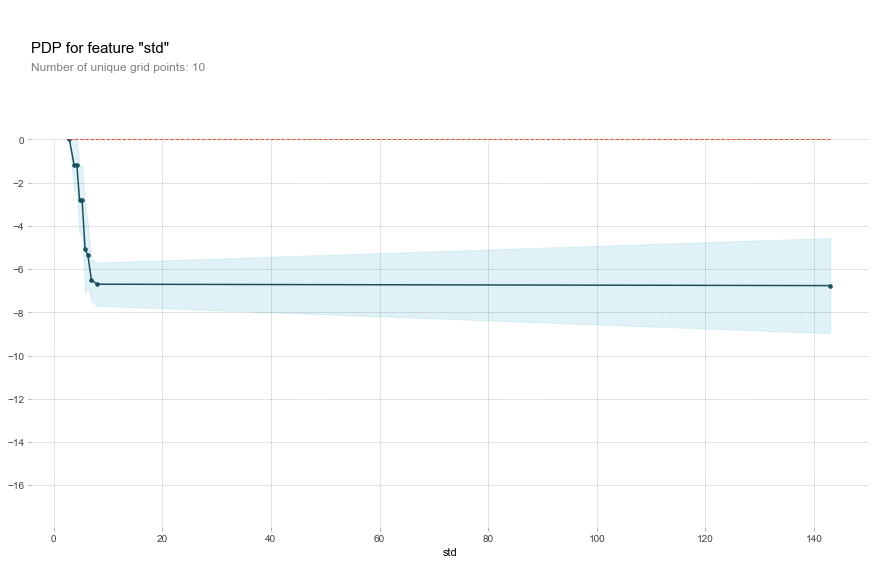

In [30]:
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=X.columns, feature='std')

pdp.pdp_plot(pdp_goals, 'std')
plt.show()

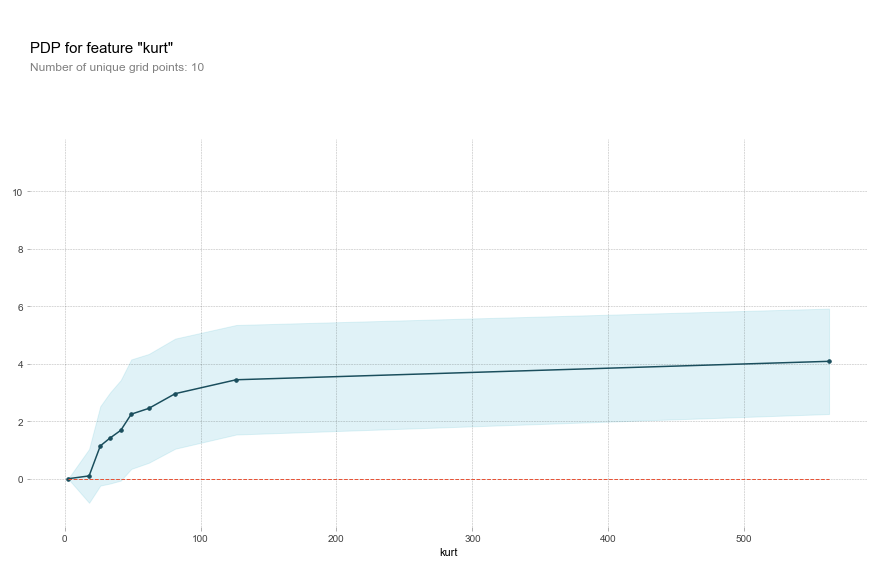

In [32]:
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='kurt')


pdp.pdp_plot(pdp_goals, 'kurt')
plt.show()

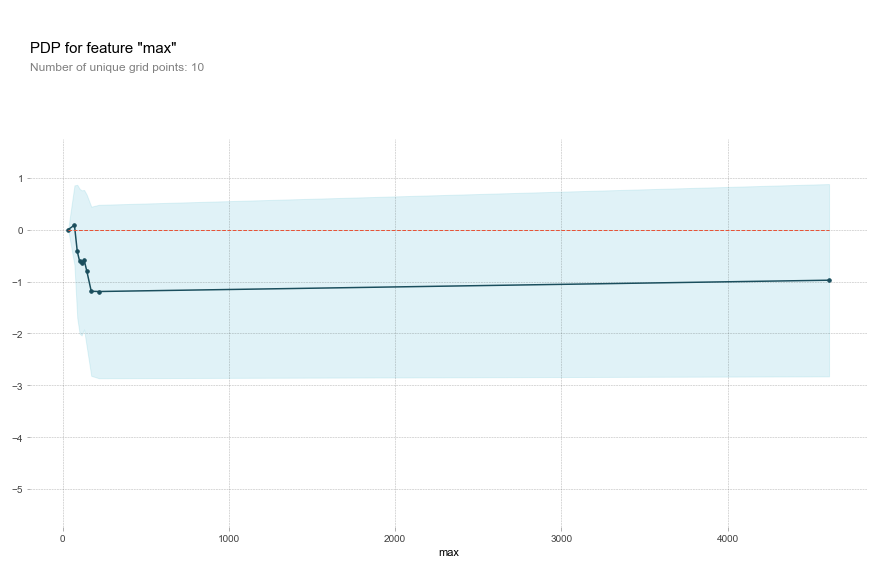

In [33]:
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='max')

pdp.pdp_plot(pdp_goals, 'max')
plt.show()

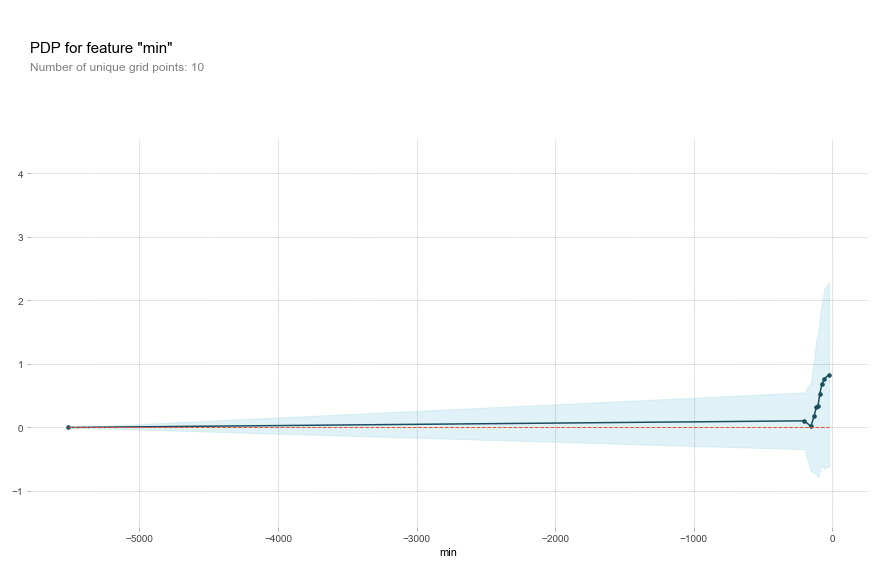

In [34]:
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='min')

pdp.pdp_plot(pdp_goals, 'min')
plt.show()

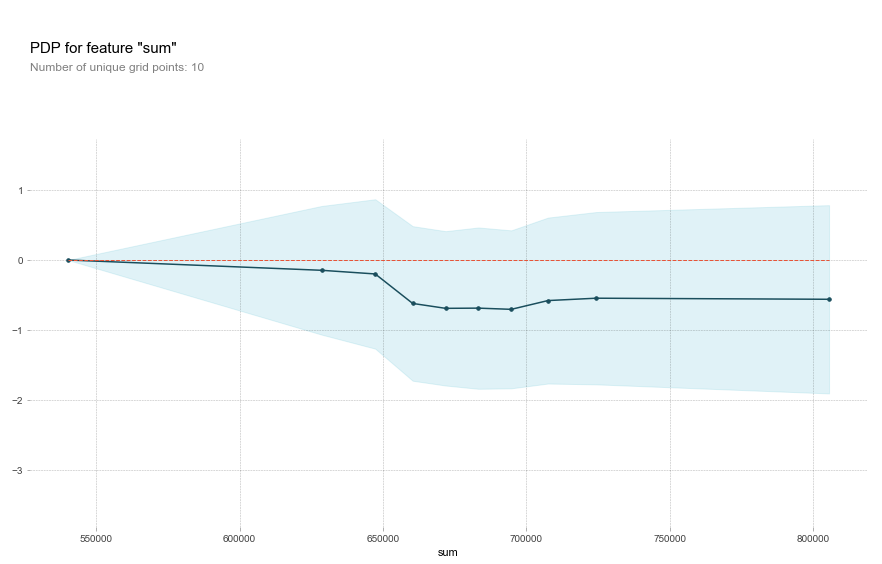

In [36]:
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='sum')

pdp.pdp_plot(pdp_goals, 'sum')
plt.show()

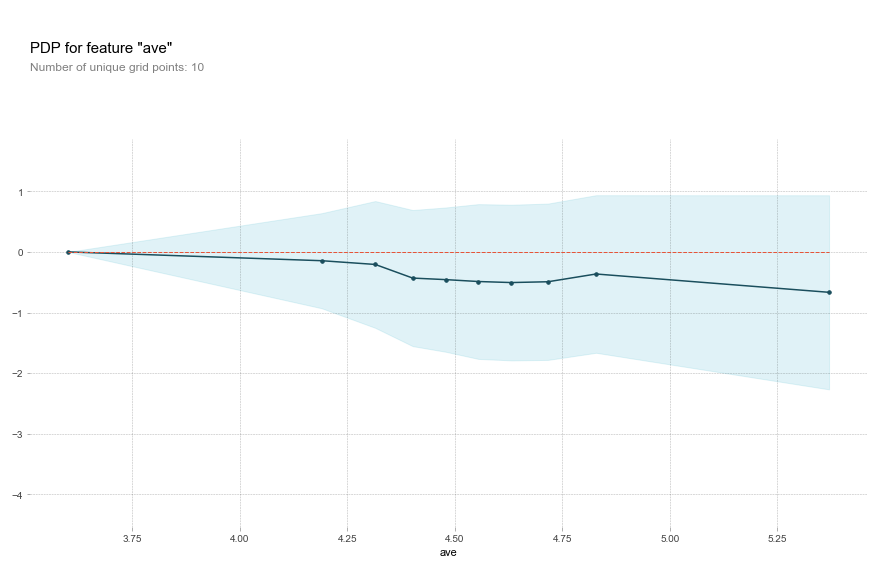

In [37]:
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='ave')

pdp.pdp_plot(pdp_goals, 'ave')
plt.show()

# Step 6. Model 

### Step 6-1. NuSvm

In [38]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred_svm= svm.predict(X_test_scaled)

### Step 6-2. LGBM

In [39]:
params = {'objective' : "regression", 
               'boosting':"gbdt",
               'metric':"mae",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.001,
               'num_leaves' : 52,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.85,
               'bagging_freq' : 1,
               'bagging_fraction' : 0.85,
               'min_data_in_leaf' : 10,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : -1}

In [40]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
y_pred_lgb = np.zeros(len(X_test_scaled))
for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X))):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
    model = lgb.LGBMRegressor(**params, n_estimators = 22000, n_jobs = -1)
    model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
            
    y_pred_valid = model.predict(X_valid)
    y_pred_lgb += model.predict(X_test_scaled, num_iteration=model.best_iteration_) / folds.n_splits

0it [00:00, ?it/s]

Fold 0 started at Thu Jun 13 13:44:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.64389	valid_1's l1: 2.72635
[2000]	training's l1: 1.93743	valid_1's l1: 2.25638
Early stopping, best iteration is:
[2525]	training's l1: 1.83699	valid_1's l1: 2.24129


1it [00:08,  8.49s/it]

Fold 1 started at Thu Jun 13 13:44:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.63837	valid_1's l1: 2.74406
[2000]	training's l1: 1.93662	valid_1's l1: 2.24109
Early stopping, best iteration is:
[2791]	training's l1: 1.80341	valid_1's l1: 2.20921


2it [00:17,  8.56s/it]

Fold 2 started at Thu Jun 13 13:44:48 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.64152	valid_1's l1: 2.66233
[2000]	training's l1: 1.92423	valid_1's l1: 2.24909
Early stopping, best iteration is:
[2273]	training's l1: 1.86405	valid_1's l1: 2.24143


3it [00:24,  8.10s/it]

Fold 3 started at Thu Jun 13 13:44:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.63169	valid_1's l1: 2.77021
[2000]	training's l1: 1.9493	valid_1's l1: 2.16586
[3000]	training's l1: 1.79338	valid_1's l1: 2.12511
Early stopping, best iteration is:
[2843]	training's l1: 1.81027	valid_1's l1: 2.12422


4it [00:32,  8.24s/it]

Fold 4 started at Thu Jun 13 13:45:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.62237	valid_1's l1: 2.81939
[2000]	training's l1: 1.93023	valid_1's l1: 2.28453
[3000]	training's l1: 1.77071	valid_1's l1: 2.24863
Early stopping, best iteration is:
[3073]	training's l1: 1.76338	valid_1's l1: 2.24833


5it [00:42,  8.56s/it]


### Step 6-3. Catboost

In [42]:
train_pool = Pool(X,y)
cat_model = CatBoostRegressor(
                               iterations=1000,
                               learning_rate=0.03,
                               eval_metric='MAE',
                              )
cat_model.fit(X,y,silent=True)
y_pred_cat = cat_model.predict(X_test)

# Step 7. Submission

In [43]:
submission['time_to_failure'] = y_pred_svm
submission.to_csv('submission_svm.csv')

In [44]:
submission['time_to_failure'] = y_pred_lgb
submission.to_csv('submission_lgb.csv')

In [45]:
submission['time_to_failure'] = y_pred_cat
submission.to_csv('submission_cat.csv')

### Step 7-1. Blending

In [46]:
blending = y_pred_svm*0.5 + y_pred_lgb*0.5 
submission['time_to_failure']=blending
submission.to_csv('submission_lgb_svm.csv')

In [47]:
blending = y_pred_svm*0.5 + y_pred_cat*0.5 
submission['time_to_failure']=blending
submission.to_csv('submission_cat_svm.csv')